# Example 1 - Simple Markov Chain

Here we'll use a simple two state markov chain with an absorbing state.

![Markov Decision Problem](../../assets/example_1.png)

The state and action spaces are:

$$ S = \{ \mathrm{S0}, \mathrm{S1} \}$$
$$ A = \{ \mathrm{A0}, \mathrm{A1} \}$$

Note that if we're in state S0, we can choose either A0 or A1. A0 has a half chance of leaving us in S0 and giving payoff 5, and a half chance of moving us to state S1 with payoff 5. A1 moves us directly to S1 and we get payoff 10.

When I'm in state S1, I can only choose action A1, which leaves me in S1 and gives -1 payoff.


Our transition and reward matrices are:

Action 0

$$ P_{0} = \begin{pmatrix} \frac{1}{2} & \frac{1}{2} \\ 0 & 0 \end{pmatrix} \quad R_{0} = \begin{pmatrix} 5 & 5 \\ 0 & 0 \end{pmatrix}$$

Action 1

$$ P_{0} = \begin{pmatrix} 0 & 1 \\ 0 & 1 \end{pmatrix} \quad R_{0} = \begin{pmatrix} 0 & 10 \\ 0 & -1 \end{pmatrix}$$


**Be aware of:**

The PyMDPToolbox package we use to solve the problems require that the transition matrices be valid Markov matrices (rows must sum to 1).

In this setup we are unable to choose action A0 if we're in state S1. So the transition matrix for this action has a row of 0s in the "current state = S1" row.

To fix this, we find rows that sum to 0; place a 1 on the diagonal elements; and replace the corresponding reward with a very negative number.

We should choose that negative number to be something smaller than the smallest payoff; like -1e-8. We can't set it to - $\infty$, because then after matrix multiplications everything will come out as infinities.

Our new transition and reward matrices are:


Action 0

$$ P_{0} = \begin{pmatrix} \frac{1}{2} & \frac{1}{2} \\ 0 & 1 \end{pmatrix} \quad R_{0} = \begin{pmatrix} 5 & 5 \\ 0 & -1e8 \end{pmatrix}$$

Action 1

$$ P_{0} = \begin{pmatrix} 0 & 1 \\ 0 & 1 \end{pmatrix} \quad R_{0} = \begin{pmatrix} 0 & 10 \\ 0 & -1 \end{pmatrix}$$


**Solution**

If this problem goes for one period, then the solution should be that we pick action A1 no matter what state we're in. If we're in state 1, A0 gives expected reward of 5; whereas A1 gives expected reward of 10. In state S1, we can only pick A1 which gives reward -1. So our policy and value functions for a one period problem are:

$$\mathrm{policy} = \begin{bmatrix} 1\\ 1 \end{bmatrix} \quad \mathrm{value}_{0} = \begin{bmatrix}10 \\ -1 \end{bmatrix}$$


If this is a two period problem, $t \in \{1, 0\}$, then the solution is

$$\mathrm{policy} = \begin{bmatrix} 0 & 1\\ 1 & 1 \end{bmatrix} \quad \mathrm{value}_{0} = \begin{bmatrix} 9.5 & 10 \\ -2 & -1 \end{bmatrix}$$


Let's verify that we get these solutions.

In [1]:
import pandas as pd

from rich import print
from rich.pretty import pprint

from markov_decision_process import TimeAugmentedMDP

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette("deep")
%matplotlib inline

import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

#### Step 1: Set up class that inherits from TimeAugmentedMDP


The class must be initialized with lists for S (state space), A (action space), and T (time intervals).

Define functions called `transition` and `reward`. These take the variables s_prime, s, t, a. (next state, current state, current time, action).

transition returns the transition probability for that event. reward returns the reward.

In [2]:
class MDPProblem(TimeAugmentedMDP):
    def __init__(self):
        super().__init__()

        self.S: list[str] = ["S0", "S1"]
        self.A: list[str] = ["A0", "A1"]
        self.T: list[int] = [-1, 0]

        return None

    def transition(self, s_prime, s, t, a):
        if a == "A0":
            if s == "S0" and s_prime == "S0":
                return 0.5
            if s == "S0" and s_prime == "S1":
                return 0.5

        if a == "A1":
            if s == "S0" and s_prime == "S1":
                return 1
            if s == "S1" and s_prime == "S1":
                return 1

        return 0

    def reward(self, s_prime, s, t, a):
        if a == "A0":
            if s == "S0" and s_prime == "S0":
                return 5
            if s == "S0" and s_prime == "S1":
                return 5

        if a == "A1":
            if s == "S0" and s_prime == "S1":
                return 10
            if s == "S1" and s_prime == "S1":
                return -1

        return self.INFEASIBLE

#### Step 2: Run the necessary functions

In [3]:
mdp = MDPProblem()
mdp.solve()

print("Policy:")
pprint(mdp.policy_function, expand_all=True)

print("Value Function:")
pprint(mdp.value_function, expand_all=True)

INFO:markov_decision_process.time_augmented_mdp:State space augmented with time
INFO:markov_decision_process.time_augmented_mdp:MDP solved


Policy:

{
│   -1: {
│   │   'S0': 'A0',
│   │   'S1': 'A1'
│   },
│   0: {
│   │   'S0': 'A1',
│   │   'S1': 'A1'
│   }
}

Value Function:

{
│   -1: {
│   │   'S0': 9.5,
│   │   'S1': -2.0
│   },
│   0: {
│   │   'S0': 10.0,
│   │   'S1': -1.0
│   }
}

#### Let's break what happens under the hood

In [4]:
# Instantiate the problem
mdp = MDPProblem()

In [5]:
mdp.create_data_frame()

# This sets up our problems and creates a time augmented state space. Note the
# addition of a dummy 'final period'. That's just computational hackery.
print(mdp.S_augmented)

# Then  creates an attribute `data` for the MDP object. It is a pandas DataFrame that has columns for s_prime, s, t, t_prime, a.
mdp.data.head()

INFO:markov_decision_process.time_augmented_mdp:State space augmented with time


[('S0', -1), ('S0', 0), ('S0', 1), ('S1', -1), ('S1', 0), ('S1', 1)]

,s_prime,s,a,t,t_prime
0,S0,S0,A0,-1,0
0,S1,S0,A0,-1,0
6,S0,S1,A0,-1,0
6,S1,S1,A0,-1,0
3,S0,S0,A1,-1,0


In [6]:
mdp.compute_transitions_and_rewards()

# Thisk applies our transition and reward functions defined in our class to the data frame
# Note that this method allows us to specify functions that use string logic and such.
# It does a .apply() on the dataframe, which is slow but okay for small problems.
# For larger problems, we would want to use numpy arrays and vectorize our functions.
mdp.data.head()

,s_prime,s,a,t,t_prime,probability,reward
0,S0,S0,A0,-1,0,0.5,5.0
0,S1,S0,A0,-1,0,0.5,5.0
6,S0,S1,A0,-1,0,0.0,-100000000.0
6,S1,S1,A0,-1,0,0.0,-100000000.0
3,S0,S0,A1,-1,0,0.0,-100000000.0


In [7]:
mdp.build_matrices()

# This converts the data frame into a transition matrix and a reward matrix

print("Transition Matrix:")

matrix = mdp.transitions[0].todense()
labels = mdp.S_augmented

pd.DataFrame(matrix, columns=labels, index=labels)

Transition Matrix:

,"(S0, -1)","(S0, 0)","(S0, 1)","(S1, -1)","(S1, 0)","(S1, 1)"
"(S0, -1)",0.0,0.5,0.0,0.0,0.5,0.0
"(S0, 0)",0.0,0.0,0.5,0.0,0.0,0.5
"(S0, 1)",0.0,0.0,0.0,0.0,0.0,0.0
"(S1, -1)",0.0,0.0,0.0,0.0,0.0,0.0
"(S1, 0)",0.0,0.0,0.0,0.0,0.0,0.0
"(S1, 1)",0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
mdp._solver()

# Enforces that the transition matrices are valid markov, and uses the PyMDPToolbox to solve the MDP

INFO:markov_decision_process.time_augmented_mdp:MDP solved


### Plot the transition matrices

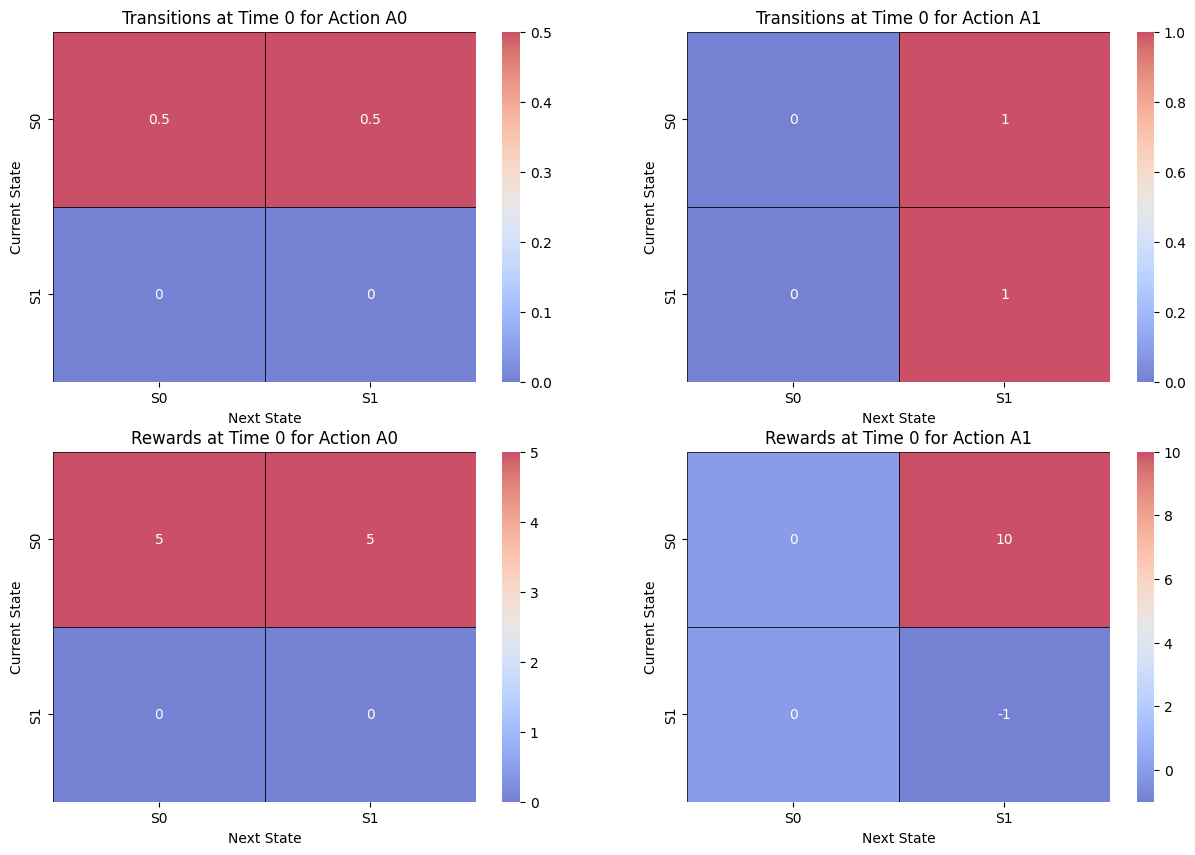

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# Plot the transition matrix for actions A1 and A2
mdp.plot_matrix(
    matrix_type="transitions", t=0, a="A0", ax=ax[0, 0], annotate=True
)
mdp.plot_matrix(
    matrix_type="transitions", t=0, a="A1", ax=ax[0, 1], annotate=True
)
mdp.plot_matrix(matrix_type="rewards", t=0, a="A0", ax=ax[1, 0], annotate=True)
mdp.plot_matrix(matrix_type="rewards", t=0, a="A1", ax=ax[1, 1], annotate=True)

plt.show()

Easy, right?